In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from scipy.stats import randint, uniform

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder as LE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import learning_curve

warnings.filterwarnings("ignore")

print("All libraries loaded")

All libraries loaded


In [12]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [13]:

data = data[data['Tipo'] != 'PR']

data = data[data['Tipo'] != 'HC']

data = data[data['Diagnostico '] != 'CN']

conteo_clases = data['Diagnostico '].value_counts()

print(conteo_clases)

Diagnostico 
PDD    43
MCI    33
Name: count, dtype: int64


In [14]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data.dropna(subset=['Tipo'], inplace=True)

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Tipo'],inplace=True)


data['TipoDeDiagnostico'] = data['Diagnostico '].map({'CN': 1, 'MCI': 2, 'PDD': 3})
data.drop(columns=['Diagnostico '], inplace=True)

data = data.dropna()

conteo_clases = data['TipoDeDiagnostico'].value_counts()

print(conteo_clases)
print(data.info())

TipoDeDiagnostico
3    35
2    31
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 2 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           66 non-null     float64
 1   Ángulo manecillas 2pm             66 non-null     float64
 2   Ángulo manecillas 11am            66 non-null     float64
 3   Números detectados correctamente  66 non-null     int64  
 4   Números con error espacial        66 non-null     int64  
 5   Números algo detectado            66 non-null     int64  
 6   Total numeros detectados          66 non-null     int64  
 7   Puntuacion contorno               66 non-null     int64  
 8   Puntuacion manecillas             66 non-null     int64  
 9   Puntuacion numeros                66 non-null     int64  
 10  puntuacion final                  66 non-null     int64  
 11  Area Circulo     

In [15]:
from sklearn.preprocessing import OneHotEncoder

X = data.drop(columns=['TipoDeDiagnostico'])
y = data['TipoDeDiagnostico']

X = X.dropna()
y = y[X.index]

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 2 to 225
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           66 non-null     float64
 1   Ángulo manecillas 2pm             66 non-null     float64
 2   Ángulo manecillas 11am            66 non-null     float64
 3   Números detectados correctamente  66 non-null     int64  
 4   Números con error espacial        66 non-null     int64  
 5   Números algo detectado            66 non-null     int64  
 6   Total numeros detectados          66 non-null     int64  
 7   Puntuacion contorno               66 non-null     int64  
 8   Puntuacion manecillas             66 non-null     int64  
 9   Puntuacion numeros                66 non-null     int64  
 10  puntuacion final                  66 non-null     int64  
 11  Area Circulo                      66 non-null     float64
 12  Circularidad  

Datos de entrenamiento: (10, 21), Datos de validación: (5, 21), Datos de prueba ciega: (27, 21)


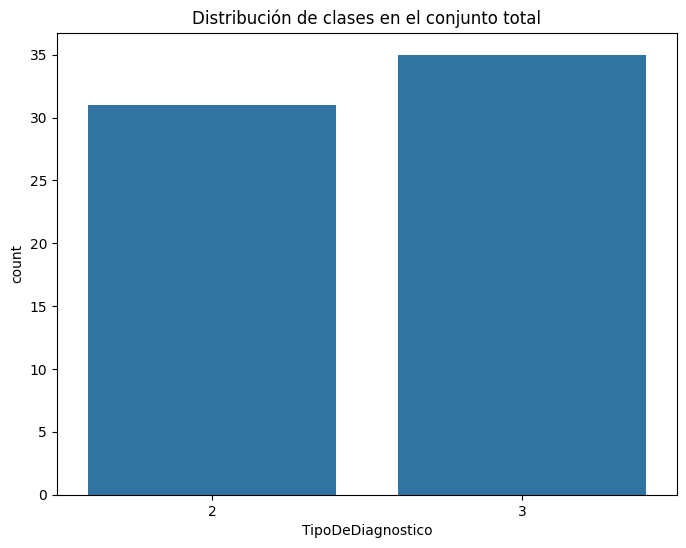

TipoDeDiagnostico
3    35
2    31
Name: count, dtype: int64


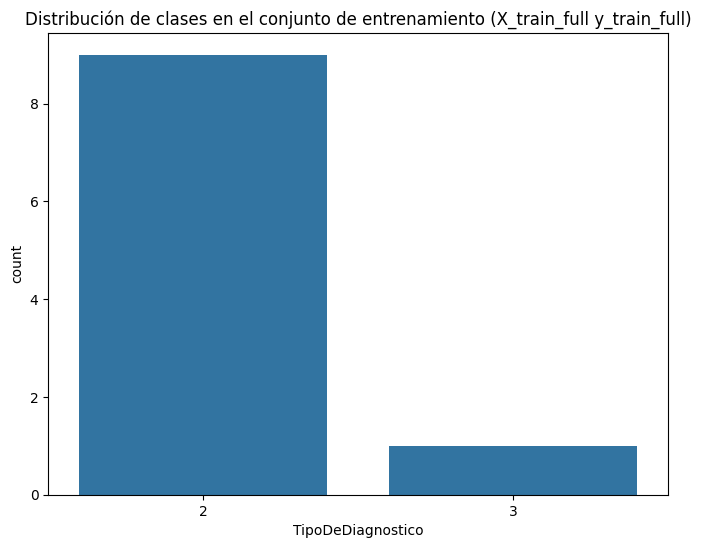

TipoDeDiagnostico
2    9
3    1
Name: count, dtype: int64


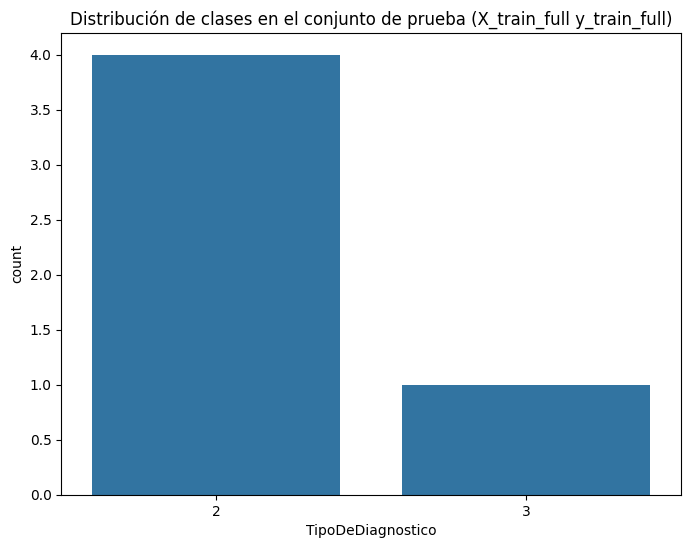

TipoDeDiagnostico
2    4
3    1
Name: count, dtype: int64


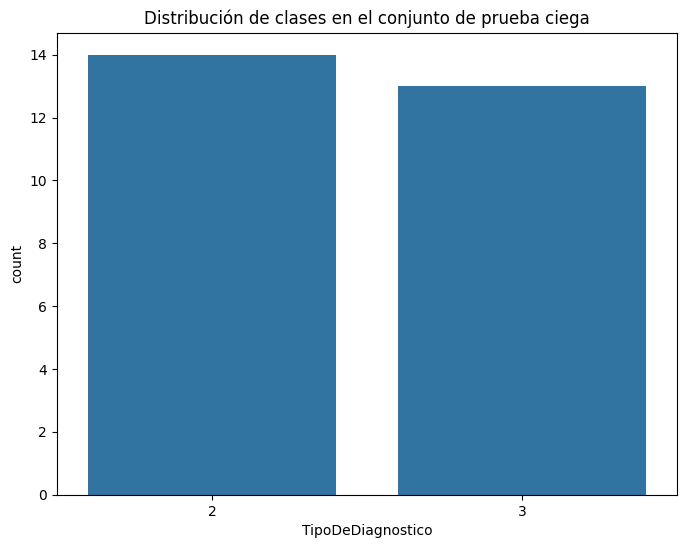

TipoDeDiagnostico
2    14
3    13
Name: count, dtype: int64


In [16]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.4, random_state=42)  

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np

borderline_smote = BorderlineSMOTE(random_state=42)
X_train_bs, y_train_bs = borderline_smote.fit_resample(X_train, y_train)

noise = np.random.normal(0, 0.05, X_train_bs.shape) 
X_train_noisy = X_train_bs + noise

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_noisy)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: {X_test_full.shape}, Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_full)
plt.title('Distribución de clases en el conjunto de prueba (X_train_full y_train_full)')
plt.show()
print(y_test_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba ciega')
plt.show()
print(y_test_blind.value_counts())